In [2]:
!pip install tensorboardcolab

  Created wheel for tensorboardcolab: filename=tensorboardcolab-0.0.22-py3-none-any.whl size=3857 sha256=8ff9ea5db4508915e20cd938c60a1391d8a30da8df21b2b47f0e89094408ebd2
  Stored in directory: /root/.cache/pip/wheels/69/4e/4a/1c6c267395cb10edded1050df12af165d3254cfce324e80941
Successfully built tensorboardcolab


In [3]:
from tensorflow.keras.utils import to_categorical
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPool2D, BatchNormalization 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback, TensorBoard
from tensorboardcolab import TensorBoard, TensorBoardColabCallback
from sklearn.preprocessing import LabelBinarizer
from tensorflow.nn import local_response_normalization

In [4]:
# 모델링 
input_shape = (227, 227, 3) # 논문 제시 shape 
x = Input(shape = input_shape, name = 'Input')

# layer_1 
conv1 = Conv2D(filters = 96, kernel_size= (11,11), strides = 4, activation='relu', name = "Conv_1")(x)
pool1 = MaxPool2D((3,3), strides = 2, name = 'Pool_1')(conv1)
output_1 = BatchNormalization(name = "output_1")(pool1)

# layer_2 
conv2 = Conv2D(filters = 256, kernel_size=(5,5), strides = 1, padding='same', activation='relu', name = 'Conv_2')(output_1)
pool2 = MaxPool2D((3,3), strides = 2, name = 'Pool_2' )(conv2)
output_2 = BatchNormalization(name = 'output_2')(pool2)

# layer_3 
conv3 = Conv2D(filters = 384, kernel_size=(3,3), strides = 1, padding='same', activation = 'relu', name = 'Conv_3')(output_2)

# layer_4 
conv4 = Conv2D(filters = 384, kernel_size=(3,3), strides = 1, padding='same', activation = 'relu', name = 'Conv_4')(conv3)

# layer_5
conv5 = Conv2D(filters = 256, kernel_size=(3,3), strides = 1, padding='same', activation = 'relu', name = 'Conv_5')(conv4)
pool3 = MaxPool2D((3,3), strides=2, name = 'Pool_3')(conv5)

# fully_connected
fc = Flatten()(pool3)
fc = Dense(4096, activation='relu', name='FC_1')(fc)
fc = Dropout(0.5)(fc)

fc = Dense(4096, activation='relu', name='FC_2')(fc)
fc = Dropout(0.5)(fc)

output = Dense(1000, activation='softmax', name = 'Output')(fc)

In [5]:
model = Model(x, output)

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 227, 227, 3)]     0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
Pool_1 (MaxPooling2D)        (None, 27, 27, 96)        0         
_________________________________________________________________
output_1 (BatchNormalization (None, 27, 27, 96)        384       
_________________________________________________________________
Conv_2 (Conv2D)              (None, 27, 27, 256)       614656    
_________________________________________________________________
Pool_2 (MaxPooling2D)        (None, 13, 13, 256)       0         
_________________________________________________________________
output_2 (BatchNormalization (None, 13, 13, 256)       1024  

In [7]:
# CIFAR10 dataset 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1], x_train.shape[2], x_train.shape[3]

170508288/170498071 [==============================] - 3s 0us/step


In [8]:
# 227,227이 아니라 32, 32 임 
x_train.shape

(50000, 32, 32, 3)

In [9]:
y_train, y_train.shape

(array([[6],
        [9],
        [9],
        ...,
        [9],
        [1],
        [1]], dtype=uint8), (50000, 1))

In [10]:
batch_size = 128 
num_class = 10 
epochs = 10

# 훈련 데이터의 개수가 n이고 클래스의 개수가 k일 때, 
# to_categorical 함수는 입력받은 (n) 크기의 1차원 정수 배열을 (n, k) 크기의 2차원 배열로 변경합니다. 
# 이 배열의 두 번째 차원의 인덱스가 클래스 값을 의미합니다. 
# 예를 들어 to_categorical([0, 2])는 [[1, 0, 0], [0, 0, 1]]을 반환합니다. 
y_train = to_categorical(y_train, num_class)
y_test = to_categorical(y_test, num_class)

In [11]:
y_train, y_train.shape

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]], dtype=float32), (50000, 10))

In [12]:
model = Sequential()
# model.add(Conv2D(96, (11,11), strides=(4,4), activation='relu', padding='same', input_shape=(img_height, img_width, channel,)))
# for original Alexnet
model.add(Conv2D(48, (3,3), strides=(2,2), activation='relu', padding='same', input_shape=(img_height, img_width, channel,)))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2,2)))
# Local Response normalization for Original Alexnet
model.add(BatchNormalization())

model.add(Conv2D(96, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(3, 3), strides=(2,2)))
# Local Response normalization for Original Alexnet
model.add(BatchNormalization())

model.add(Conv2D(192, (3,3), activation='relu', padding='same'))
model.add(Conv2D(192, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(3, 3), strides=(2,2)))
# Local Response normalization for Original Alexnet
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(num_class, activation='softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 48)        1344      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 48)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 48)          192       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 96)          41568     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 96)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 3, 96)          384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 192)         1

In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=100, 
                    verbose=1,
                    validation_data=(x_test, y_test))

Epoch 1/100
391/391 [==============================] - 5s 10ms/step - loss: 0.2816 - accuracy: 0.9064 - val_loss: 1.1491 - val_accuracy: 0.7095
Epoch 2/100
391/391 [==============================] - 4s 10ms/step - loss: 0.2378 - accuracy: 0.9214 - val_loss: 1.1710 - val_accuracy: 0.7166
Epoch 3/100
391/391 [==============================] - 4s 9ms/step - loss: 0.2240 - accuracy: 0.9256 - val_loss: 1.2813 - val_accuracy: 0.6982
Epoch 4/100
391/391 [==============================] - 4s 10ms/step - loss: 0.1958 - accuracy: 0.9351 - val_loss: 1.3193 - val_accuracy: 0.6936
Epoch 5/100
391/391 [==============================] - 4s 10ms/step - loss: 0.1784 - accuracy: 0.9421 - val_loss: 1.2280 - val_accuracy: 0.7247
Epoch 6/100
391/391 [==============================] - 4s 10ms/step - loss: 0.1499 - accuracy: 0.9512 - val_loss: 1.2771 - val_accuracy: 0.7150
Epoch 7/100
391/391 [==============================] - 4s 10ms/step - loss: 0.1484 - accuracy: 0.9512 - val_loss: 1.4539 - val_accuracy: 

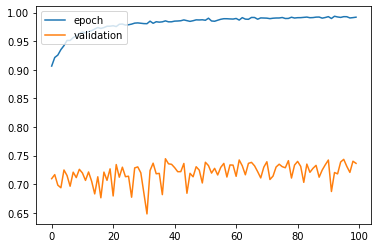

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['epoch', 'validation'], loc = 'upper left')
plt.show()

In [34]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
predictions = model.predict(x_test, verbose=1)

313/313 [==============================] - 1s 4ms/step - loss: 1.1268 - accuracy: 0.7274
Test loss: 1.1267679929733276
Test accuracy: 0.727400004863739
313/313 [==============================] - 1s 2ms/step


In [28]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axs = plt.subplots(10, 2, figsize=(12,24))
    margin = 0.05
    ind = np.arange(n_classes)
    width = (1. - 2. * margin) / n_classes    
    arr_features = [None]*10
    arr_predictions = np.zeros((10, 10))
    last_image_i = 0
    
    for i, prediction in enumerate(predictions):
        label_id = label_ids[i]
        feature = features[i]
        arr_features[label_id] = feature
        max_id = np.argmax(prediction)
        arr_predictions[label_id][max_id] += 1
        last_image_i = i

    arr_predictions /= last_image_i
    
    for i in range(10):
      feature = arr_features[i]
      pred_name = label_names[i]
      prediction = arr_predictions[i]
      axs[i][0].imshow(feature)
      axs[i][0].set_title(pred_name)
      axs[i][0].set_axis_off()

      axs[i][1].barh(ind + margin, prediction, width)
      axs[i][1].set_yticks(ind + margin)
      axs[i][1].set_yticklabels(label_names)

    plt.tight_layout()

In [30]:
x_test.shape, y_test.shape

((10000, 32, 32, 3), (10000, 10))

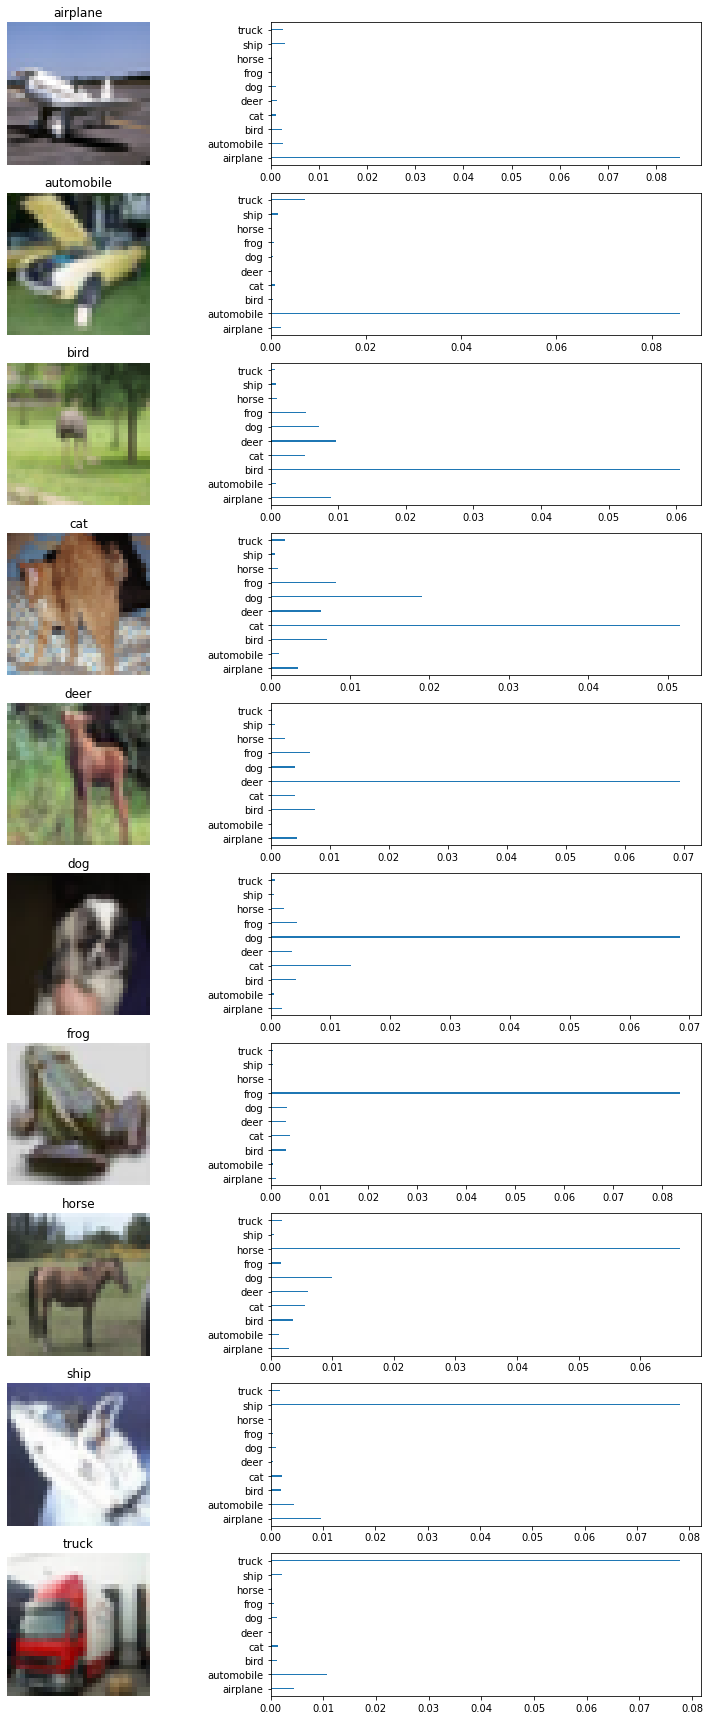

In [36]:
display_image_predictions(x_test, y_test, predictions)

In [39]:
model2 = Sequential()
# model.add(Conv2D(96, (11,11), strides=(4,4), activation='relu', padding='same', input_shape=(img_height, img_width, channel,)))
# for original Alexnet
model2.add(Conv2D(48, (3,3), strides=(2,2), activation='relu', padding='same', input_shape=(img_height, img_width, channel,)))
model2.add(MaxPool2D(pool_size=(2, 2), strides=(2,2)))
# Local Response normalization for Original Alexnet
model2.add(BatchNormalization())

model2.add(Conv2D(96, (3,3), activation='relu', padding='same'))
model2.add(MaxPool2D(pool_size=(3, 3), strides=(2,2)))
# Local Response normalization for Original Alexnet
model2.add(BatchNormalization())

model2.add(Conv2D(192, (3,3), activation='relu', padding='same'))
model2.add(Conv2D(192, (3,3), activation='relu', padding='same'))
model2.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model2.add(MaxPool2D(pool_size=(3, 3), strides=(2,2)))
# Local Response normalization for Original Alexnet
model.add(BatchNormalization())

model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(num_class, activation='softmax'))

In [40]:
model2.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history2 = model2.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=100, 
                    verbose=1,
                    validation_data=(x_test, y_test))

Epoch 1/100
391/391 [==============================] - 5s 10ms/step - loss: 1.5449 - accuracy: 0.4353 - val_loss: 1.1890 - val_accuracy: 0.5882
Epoch 2/100
391/391 [==============================] - 4s 9ms/step - loss: 1.1242 - accuracy: 0.6119 - val_loss: 1.2026 - val_accuracy: 0.5997
Epoch 3/100
391/391 [==============================] - 4s 9ms/step - loss: 0.9345 - accuracy: 0.6851 - val_loss: 1.1232 - val_accuracy: 0.6231
Epoch 4/100
391/391 [==============================] - 4s 9ms/step - loss: 0.8001 - accuracy: 0.7302 - val_loss: 1.0853 - val_accuracy: 0.6365
Epoch 5/100
391/391 [==============================] - 4s 9ms/step - loss: 0.6989 - accuracy: 0.7666 - val_loss: 1.1122 - val_accuracy: 0.6641
Epoch 6/100
391/391 [==============================] - 4s 10ms/step - loss: 0.6173 - accuracy: 0.7943 - val_loss: 1.0208 - val_accuracy: 0.6927
Epoch 7/100
391/391 [==============================] - 4s 10ms/step - loss: 0.5394 - accuracy: 0.8199 - val_loss: 1.1176 - val_accuracy: 0.6

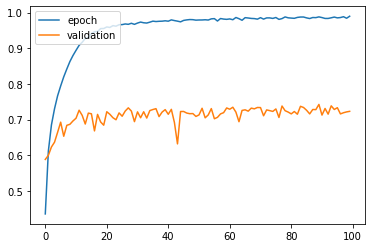

In [41]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.legend(['epoch', 'validation'], loc = 'upper left')
plt.show()

In [42]:
score = model2.evaluate(x_test, y_test, verbose = 1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
predictions = model2.predict(x_test, verbose = 1)

313/313 [==============================] - 1s 3ms/step - loss: 2.4392 - accuracy: 0.7231
Test loss: 2.4392452239990234
Test accuracy: 0.7231000065803528
313/313 [==============================] - 1s 2ms/step


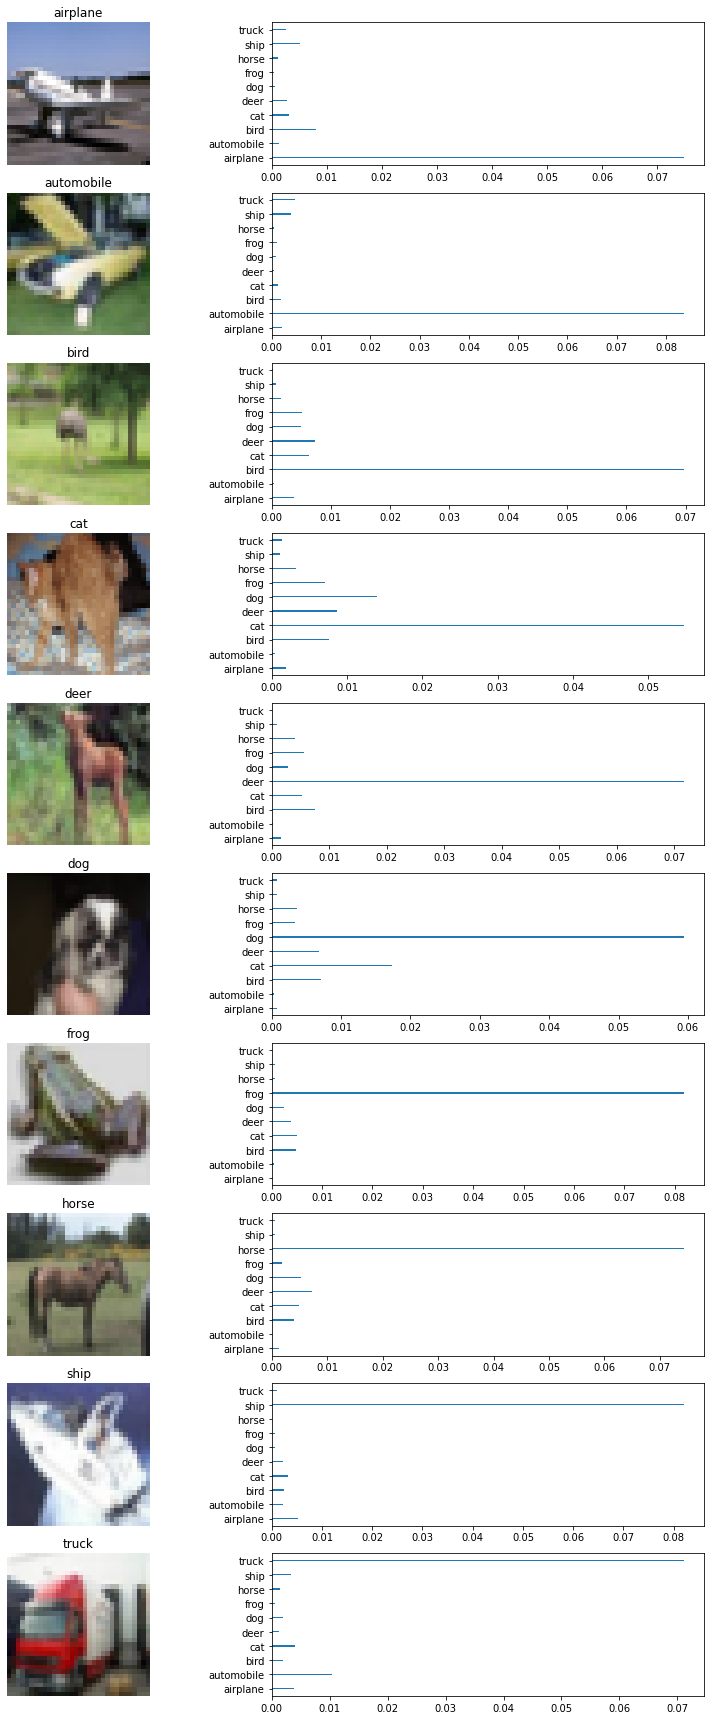

In [49]:
display_image_predictions(x_test, y_test, predictions)